In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *
torch.cuda.empty_cache()

In [6]:
### CIFAR 100
cifar100_test_acc = [0.40, 0.42, 0.41, 0.38, 0.46, 0.40, 0.41, 0.44, 0.43, 0.41, 0.40, 0.39, 0.41, 0.37, 
                     0.36, 0.44, 0.42, 0.45, 0.39, 0.39, 0.39]

cifar100_test_acc_std = [0.02, 0.03, 0.02, 0.05, 0.04, 0.03, 0.01, 0.03, 0.04, 0.06, 0.04, 0.04, 0.05, 0.03, 
                         0.06, 0.02, 0.08, 0.02, 0.09, 0.04, 0.05]

cifar100_adv_acc = [0.30, 0.29, 0.29, 0.29, 0.26, 0.29, 0.26, 0.25, 0.22, 0.24, 0.21, 0.20, 0.19, 0.19, 
                   0.16, 0.14, 0.13, 0.11, 0.09, 0.08, 0.08]

cifar100_adv_acc_std = [0.02, 0.03, 0.02, 0.02, 0.03, 0.05, 0.04, 0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.04, 
                        0.02, 0.02, 0.04, 0.03, 0.02, 0.03, 0.02]

cifar10_test_acc = [0.82, 0.81, 0.81, 0.80, 0.81, 0.83, 0.79, 0.82, 0.81, 0.78, 0.81, 0.81, 0.83, 0.82, 0.83, 0.83, 0.83, 0.84, 0.87, 0.85, 0.82]
cifar10_test_acc_std = [0.03, 0.02, 0.03, 0.07, 0.05, 0.03, 0.05, 0.05, 0.04, 0.05, 0.04, 0.03, 0.02, 0.02, 0.03, 0.03, 0.02, 0.02, 0.01, 0.02, 0.03]
cifar10_adv_acc = [0.51, 0.49, 0.48, 0.49, 0.42, 0.42, 0.39, 0.35, 0.34, 0.31, 0.24, 0.18, 0.18, 0.13, 0.11, 0.09, 0.06, 0.05, 0.04, 0.02, 0.01]
cifar10_adv_acc_std = [0.04, 0.04, 0.03, 0.02, 0.03, 0.05, 0.04, 0.03, 0.05, 0.06, 0.03, 0.04, 0.04, 0.05, 0.02, 0.03, 0.02, 0.01, 0.01, 0.02, 0.01]


### CELEBA
celeba_test_acc = [0.74, 0.70, 0.75, 0.74, 0.74, 0.76, 0.79, 0.76, 0.79, 0.75, 0.76, 0.80, 0.77, 0.80, 
                   0.80, 0.76, 0.79, 0.84, 0.84, 0.83, 0.83]

celeba_test_acc_std = [0.05, 0.03, 0.03, 0.05, 0.03, 0.03, 0.03, 0.05, 0.01, 0.06, 0.03, 0.05, 0.04, 0.04, 
                       0.07, 0.03, 0.02, 0.02, 0.06, 0.04, 0.06]

celeba_adv_acc = [0.40, 0.38, 0.41, 0.43, 0.44, 0.42, 0.43, 0.40, 0.43, 0.44, 0.42, 0.42, 0.40, 0.45, 
                  0.33, 0.35, 0.29, 0.27, 0.24, 0.20, 0.10]

celeba_adv_acc_std = [0.01, 0.04, 0.05, 0.07, 0.04, 0.05, 0.05, 0.06, 0.02, 0.04, 0.06, 0.04, 0.03, 0.02, 
                      0.04, 0.04, 0.05, 0.04, 0.05, 0.05, 0.03]


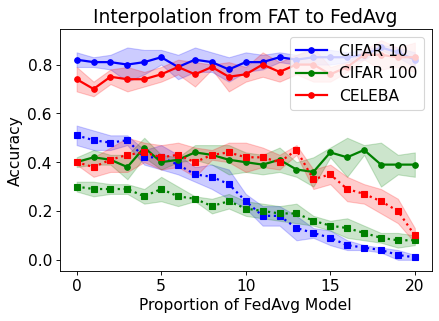

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Data for CIFAR 10, CIFAR 100, and CELEBA
# (The lists are not repeated for clarity)

# X-axis values: Replace alpha_list with appropriate x-values if different
x = np.arange(0, len(cifar10_test_acc))

font = {'family': 'normal',
        'weight': 'normal',
        'size': 14}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6, 4))  # Adjusted figure size for more lines

# Plot CIFAR 10 lines
plt.plot(x, cifar10_test_acc, label='CIFAR 10', color='b', linewidth=2, linestyle='-', marker='o', markersize=5)
plt.fill_between(x, np.array(cifar10_test_acc) - np.array(cifar10_test_acc_std),
                 np.array(cifar10_test_acc) + np.array(cifar10_test_acc_std), color='b', alpha=0.2)

plt.plot(x, cifar10_adv_acc, color='b', linewidth=2, linestyle=':', marker='s', markersize=5)
plt.fill_between(x, np.array(cifar10_adv_acc) - np.array(cifar10_adv_acc_std),
                 np.array(cifar10_adv_acc) + np.array(cifar10_adv_acc_std), color='b', alpha=0.2)

# Plot CIFAR 100 lines
plt.plot(x, cifar100_test_acc, label='CIFAR 100', color='g', linewidth=2, linestyle='-', marker='o', markersize=5)
plt.fill_between(x, np.array(cifar100_test_acc) - np.array(cifar100_test_acc_std),
                 np.array(cifar100_test_acc) + np.array(cifar100_test_acc_std), color='g', alpha=0.2)

plt.plot(x, cifar100_adv_acc, color='g', linewidth=2, linestyle=':', marker='s', markersize=5)
plt.fill_between(x, np.array(cifar100_adv_acc) - np.array(cifar100_adv_acc_std),
                 np.array(cifar100_adv_acc) + np.array(cifar100_adv_acc_std), color='g', alpha=0.2)

# Plot CELEBA lines
plt.plot(x, celeba_test_acc, label='CELEBA', color='r', linewidth=2, linestyle='-', marker='o', markersize=5)
plt.fill_between(x, np.array(celeba_test_acc) - np.array(celeba_test_acc_std),
                 np.array(celeba_test_acc) + np.array(celeba_test_acc_std), color='r', alpha=0.2)

plt.plot(x, celeba_adv_acc, color='r', linewidth=2, linestyle=':', marker='s', markersize=5)
plt.fill_between(x, np.array(celeba_adv_acc) - np.array(celeba_adv_acc_std),
                 np.array(celeba_adv_acc) + np.array(celeba_adv_acc_std), color='r', alpha=0.2)

# Set plot title and labels
plt.title('Interpolation from FAT to FedAvg')
plt.xlabel('Proportion of FedAvg Model')
plt.ylabel('Accuracy')

# Add a legend
plt.legend(loc='upper right')  # Places the legend in the upper-left corner
# Show the plot
plt.show()
